# Enhancing the Statistical Rigor of the TN Eviction Data
## - Motivation:
- During the Exploratory Analysis it became clear that at the state and county level there are some interesting relationships between some **key metrics: **
    - **poverty-rates**, 
    - **eviction-filing-rates**,
    - **eviction-rates** themselves and 
    - **racial-distributions**. 


- However, **a significant number of counties are reporting zeros for some key metrics** eviction-rates and eviction-filing rates and these values are significant to the key measurements of correlation and distributions.


- It is also the case that the **poverty rates are reported annually, but only seem to be measured periodically** (about every 5 years). *We may need to find a better proxy for anual poverty values.*
    - this means that instead of having about 16 data measurements, I really only have 4 for these variables

In [2]:
import pandas as pd
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.plotly as py
import cufflinks as cf # cufflinks binds plotly to pandas dataframes in IPython notebook.
import plotly.graph_objs as go
from plotly import tools

In [3]:
sns.set(style='darkgrid')

## Read in County Level Data

In [5]:
counties_evicts_df = pd.read_csv('data/counties.csv')
counties_evicts_df.head(3)

,GEOID,year,name,parent-location,population,poverty-rate,pct-renter-occupied,median-gross-rent,median-household-income,median-property-value,...,pct-multiple,pct-other,renter-occupied-households,eviction-filings,evictions,eviction-rate,eviction-filing-rate,low-flag,imputed,subbed
0,47001,2000,Anderson County,Tennessee,71330.0,13.14,27.49,450.0,35483.0,87500.0,...,1.14,0.07,8189.0,125.0,118.0,1.44,1.53,0,0,1
1,47003,2000,Bedford County,Tennessee,37586.0,13.14,26.46,488.0,36729.0,79000.0,...,0.77,0.05,3679.0,104.0,98.0,2.66,2.83,0,0,0
2,47005,2000,Benton County,Tennessee,16537.0,15.63,19.47,367.0,28679.0,67000.0,...,0.62,0.03,1336.0,17.0,17.0,1.27,1.27,0,0,0


## Pivot County Level Data for Time Series Plotting

In [8]:
pvt_cnty_pvty_rates = counties_evicts_df.pivot(index = 'year', columns = 'name', 
                                           values = 'poverty-rate')

pvt_cnty_evic_rates = counties_evicts_df.pivot(index = 'year', columns = 'name', values= 'eviction-rate')

pvt_cnty_filing_rates = counties_evicts_df.pivot(index = 'year', columns = 'name', values= 'eviction-filing-rate')

In [16]:
pvt_cnty_house_income = counties_evicts_df.pivot(index = 'year', columns = 'name', values = 'median-household-income')

## Visualize Opaquely Periodic Poverty Rates

In [10]:
layout = go.Layout(
    autosize = True,
    #rangeslider = True,
    #width = 1600, 
    height = 800)

pvt_cnty_pvty_rates.iplot(filename='pivoted-tn-county-poverty-timeseries', sharing = 'public',
                       #layout = layout,
                       width = 1, dash = 'line', mode = 'lines',
                      title = 'TN County Poverty Rate, 2000 - 2016', yTitle = 'Poverty %', xTitle = 'Year'
                      #rangeslider = True, 
                       )

## Visualize Counties Reporting 0 for eviction-filing rates and for eviction-rates

Text(0.5,1,'Tn Counties, Time Series of Eviction-Rate Swarmplots')

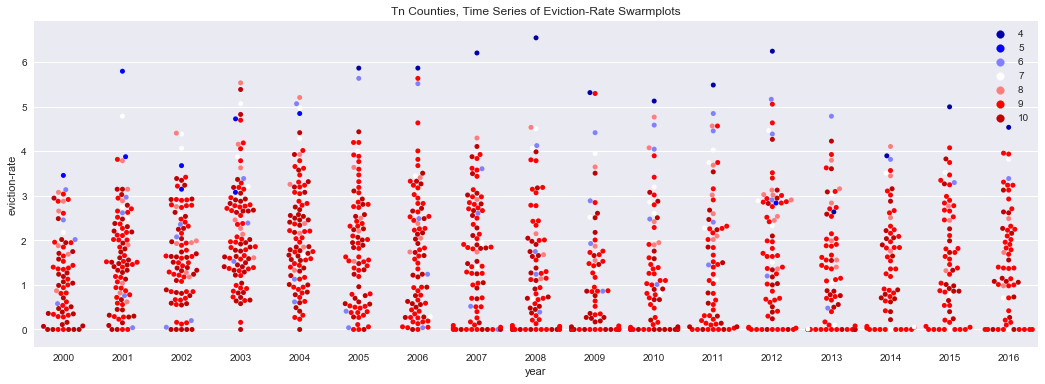

In [12]:
plt.figure(figsize=(18,6))
ax = sns.swarmplot(x = counties_evicts_df['year'], 
                   y = counties_evicts_df['eviction-rate'], 
                   hue = [round(val/10) for val in counties_evicts_df['pct-white']] , palette = 'seismic'
                  )
plt.title('Tn Counties, Time Series of Eviction-Rate Swarmplots')


Text(0.5,1,'Tn Counties, Time Series of Eviction-Rate Swarmplots')

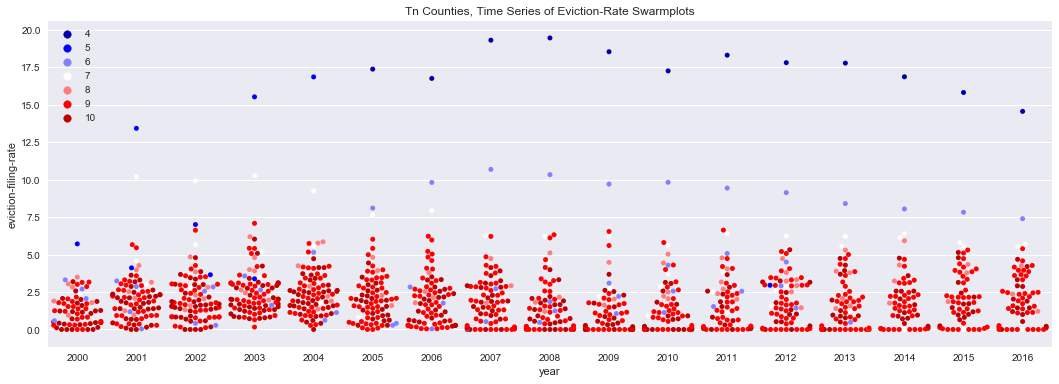

In [13]:
plt.figure(figsize=(18,6))
ax = sns.swarmplot(x = counties_evicts_df['year'], 
                   y = counties_evicts_df['eviction-filing-rate'], 
                   hue = [round(val/10) for val in counties_evicts_df['pct-white']] , palette = 'seismic'
                  )
plt.title('Tn Counties, Time Series of Eviction-Rate Swarmplots')


## Are there other metrics that report suspicioulsy zero data values?

In [40]:
select_vars = ['population',
       'poverty-rate', 'pct-renter-occupied', 'median-gross-rent',
       'median-household-income', 'median-property-value', 'rent-burden',
       'pct-white', 'renter-occupied-households',
       'eviction-filings', 'evictions', 'eviction-rate',
       'eviction-filing-rate', 'low-flag', 'imputed', 'subbed']

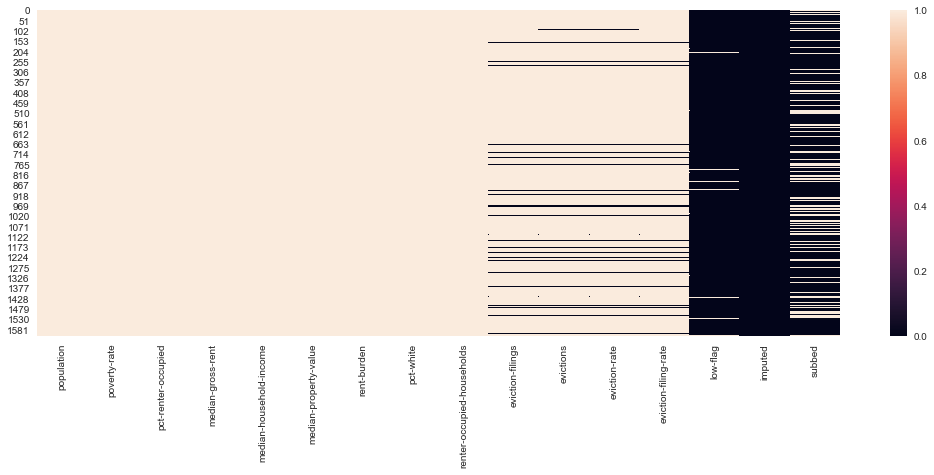

In [70]:
plt.figure(figsize=(18,6))
sns.heatmap(counties_evicts_df[select_vars] != 0)
plt.show()

**Note**
- Some counties seem to report filing data but not eviction data
    - **Is this because those counties indeed have no evicitions even though they did have filings?**
    - **Or is it because they don't report evictions as a matter of policy?**
    - check their methodology report to see if they mention anything about this.
        - if they don't, then maybe I can email them an ask about it.

**From Eviction Lab's Interactive Map**
- their interactive map makes it clear that eviction data gaps are not necessarily constant across time and county. 
## How is this possible? Why does eviction data exist for some counties in some years but not in others?

## Visualize distribution of NaNs

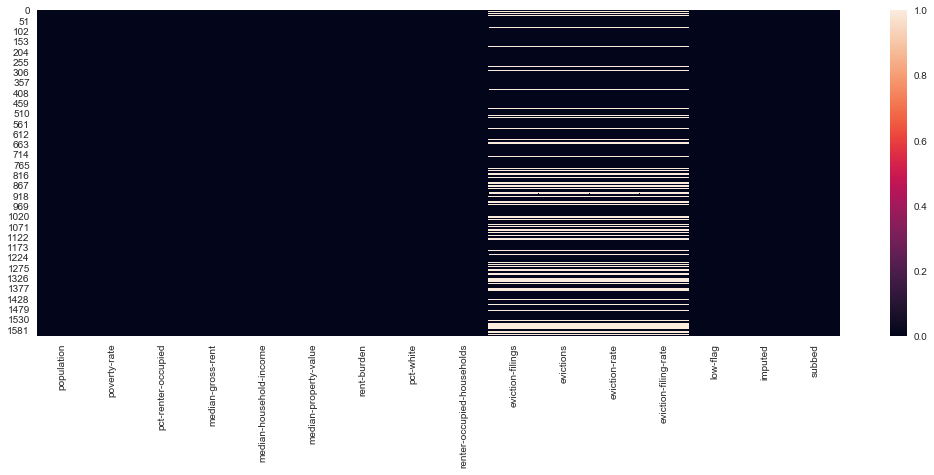

In [71]:
plt.figure(figsize=(18,6))
sns.heatmap(counties_evicts_df[select_vars].isna())
plt.show()

### Confirm there is a one-to-one correspondance between NaNs in the eviction variables
i.e. if there is an NaN in any of the eviction columns, then all the other eviction variables in that row are also NaNs

In [86]:
# for each eviction variable (other than evictions themselves):
for var in ['eviction-filings', 'eviction-rate', 'eviction-filing-rate']:
    # Confirm that each row with an NaN eviction value also has an NaN in that other eviction variable
    assert (counties_evicts_df['evictions'].isna() != counties_evicts_df[var].isna()).sum() == 0 # the sum of eviction Nan indices that are not NaN indices in the other column is zero 

### Confirm my plotting routines are handling NaNs properly

In [91]:
data = [
    go.Box(
        y = [0, 1, 2, 3, np.nan, 5, 8, 13, 21],
        boxpoints = 'all',
        jitter = 0.3,
        pointpos = -1.8
    )
]
py.iplot(data)

In [116]:
yi = np.array([0, 1, 2, 3, np.nan, 5, 8, 13, 21])
xi = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8])
mask = ~np.isnan(xi) & ~np.isnan(yi)

slope, intercept, r_value, p_value, std_err = stats.linregress(xi[mask], yi[mask])

line = slope*xi+intercept

data = [
    go.Scatter(
        y = [0, 1, 2, 3, np.nan, 5, 8, 13, 21],
        x = [0, 1, 2, 3, 4, 5, 6, 7, 8],
        mode = 'lines+markers'
    ),
    go.Scatter(
        x = xi,
        y = line,
        mode = 'lines',
        marker = go.Marker(color = 'red')
        )
]
py.iplot(data)

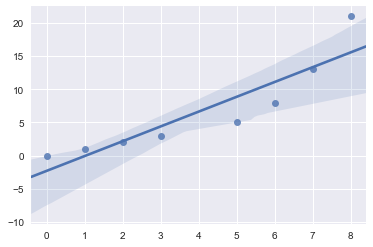

In [118]:
yi = np.array([0, 1, 2, 3, np.nan, 5, 8, 13, 21])
xi = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8])
sns.regplot(xi, yi)

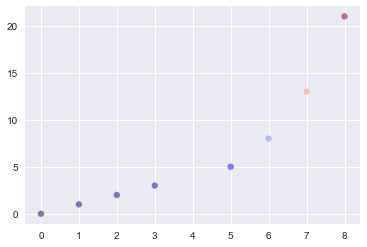

In [120]:
plt.scatter(xi, yi, edgecolors = 'white', linewidths= 1, alpha = .5, c = yi/2, cmap = 'seismic')

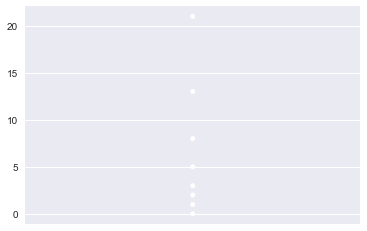

In [126]:
sns.swarmplot()

## Are there other metrics that have opaquely periodic data?

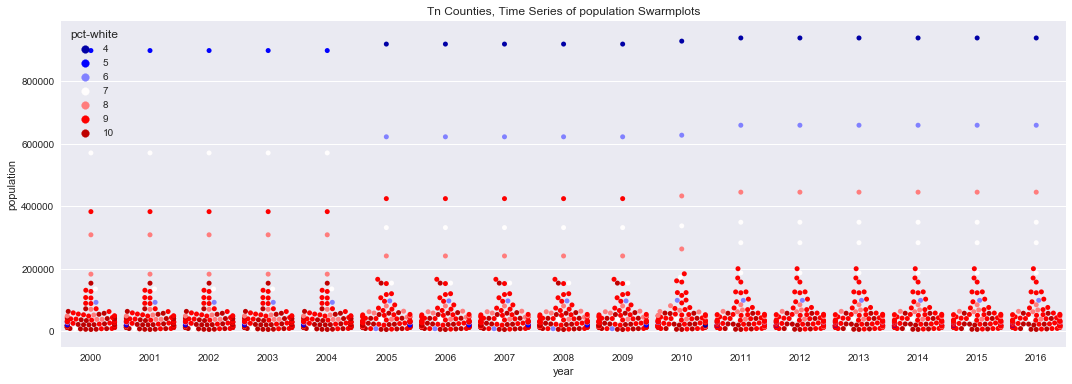

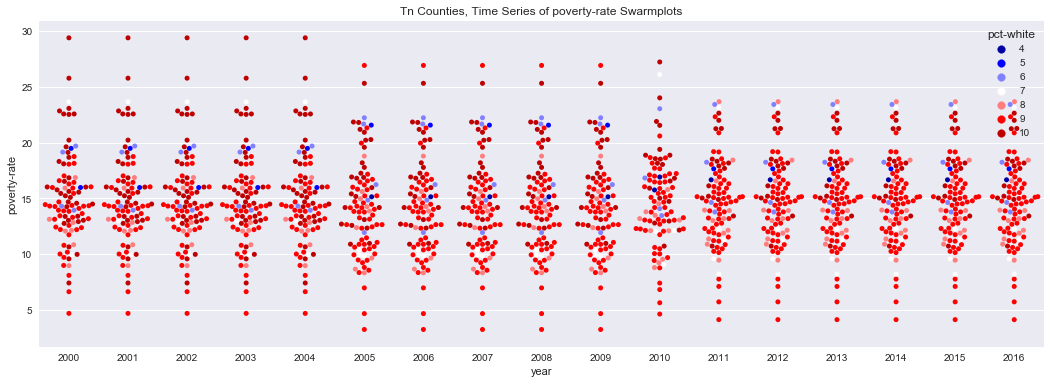

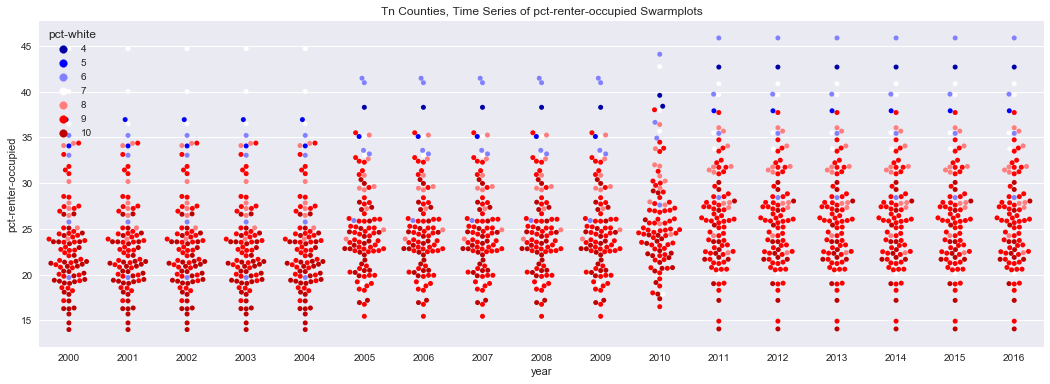

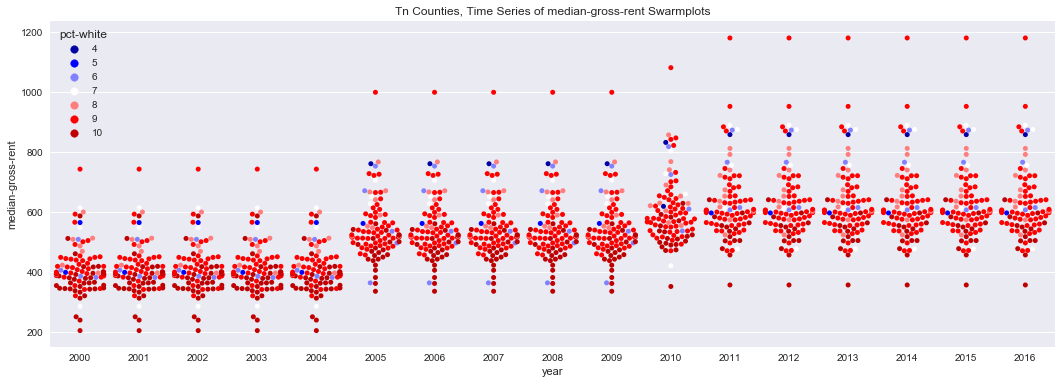

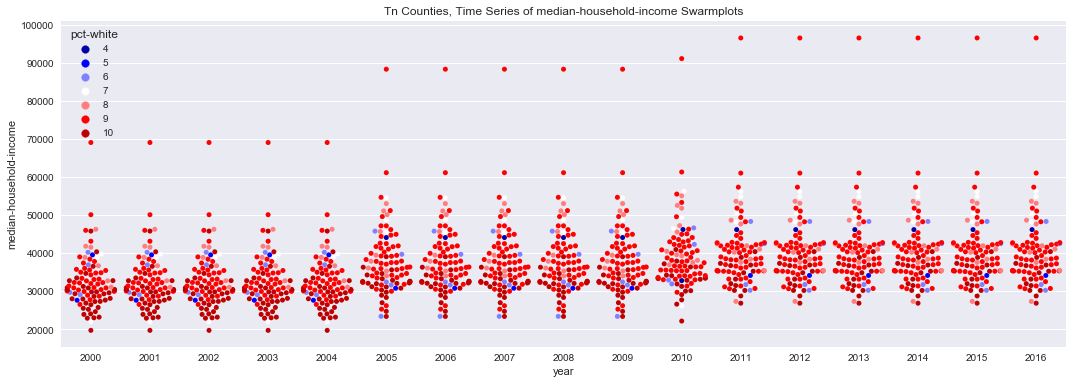

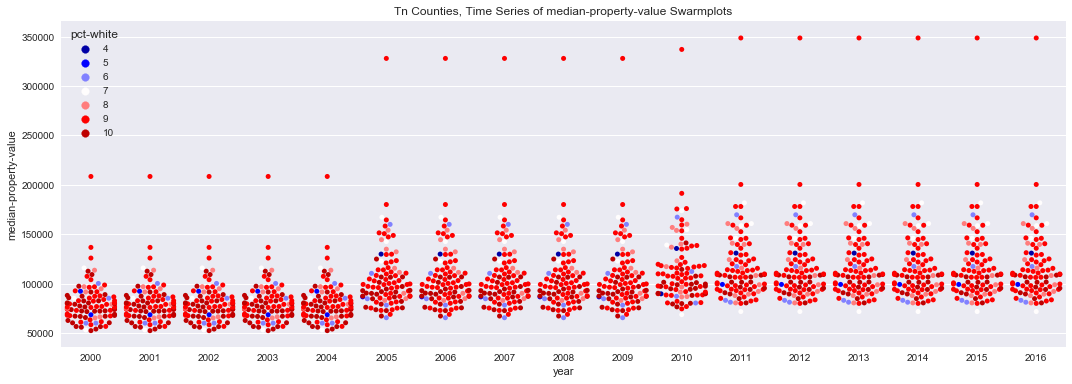

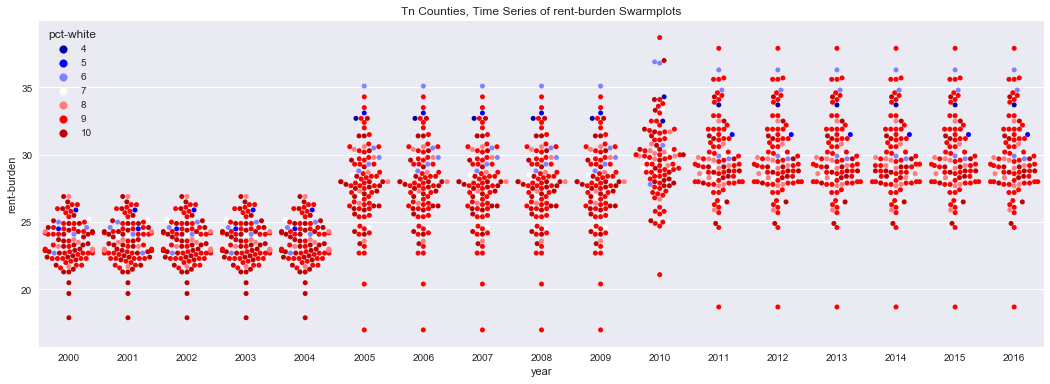

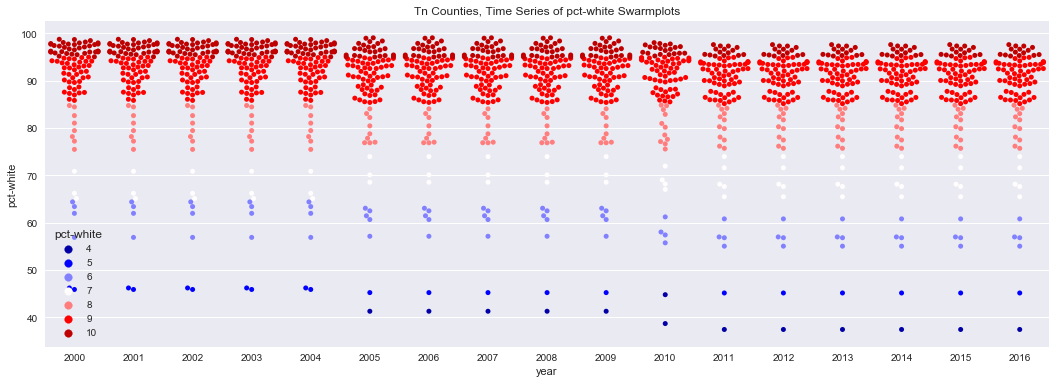

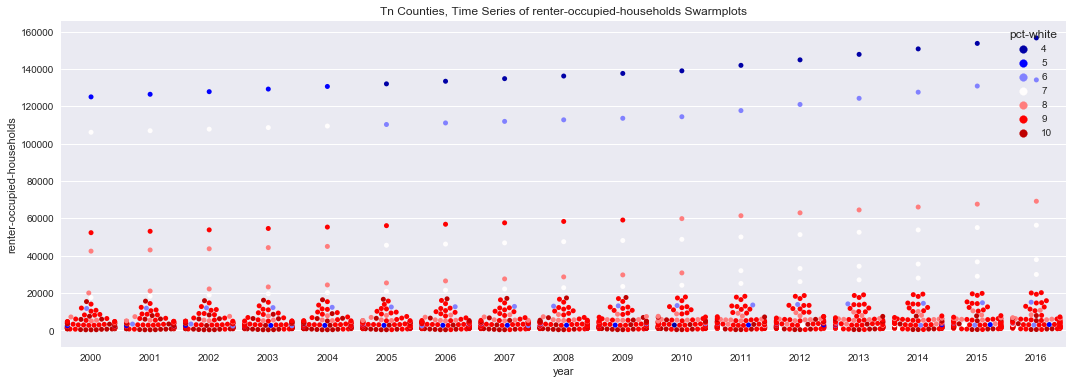

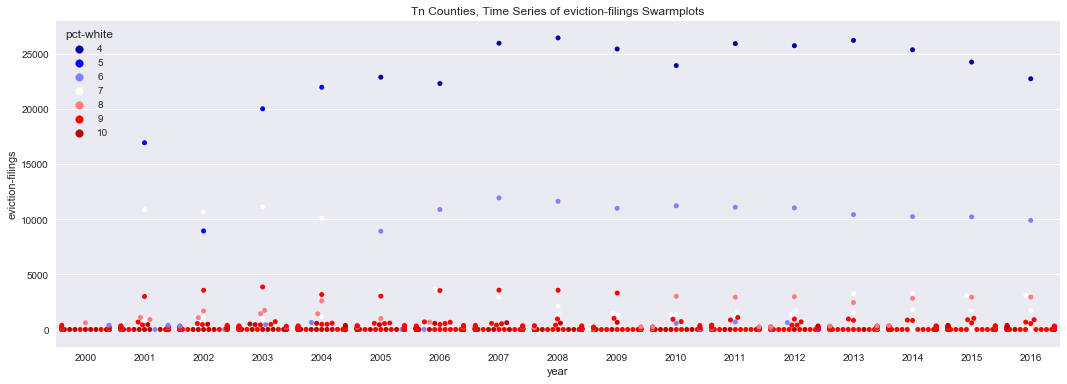

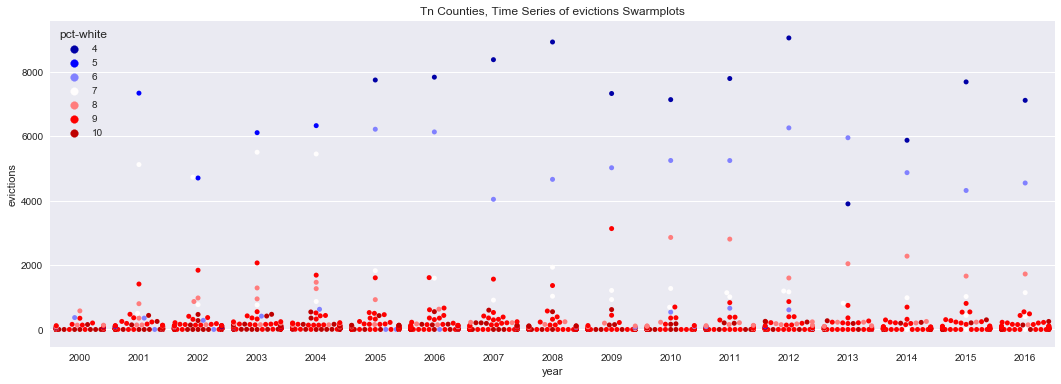

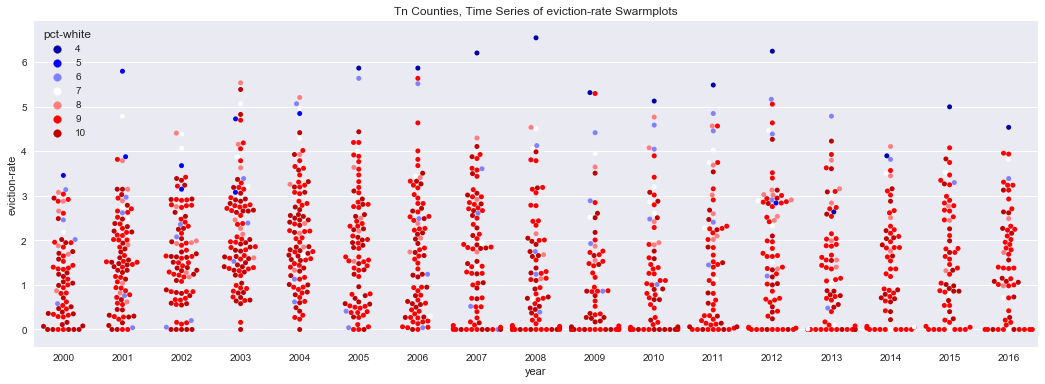

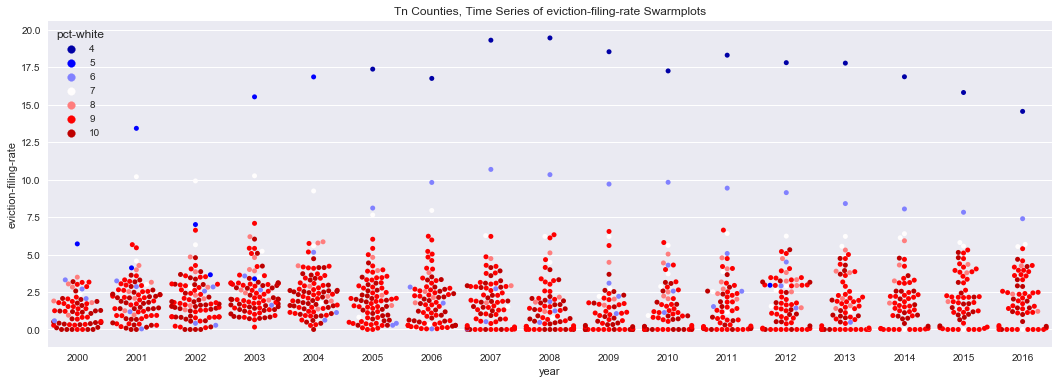

In [29]:
for var in ['population',
       'poverty-rate', 'pct-renter-occupied', 'median-gross-rent',
       'median-household-income', 'median-property-value', 'rent-burden',
       'pct-white', 'renter-occupied-households',
       'eviction-filings', 'evictions', 'eviction-rate',
       'eviction-filing-rate']:
    plt.figure(figsize=(18,6))
    ax = sns.swarmplot(x = counties_evicts_df['year'], 
                   y = counties_evicts_df[var], 
                   hue = [round(val/10) for val in counties_evicts_df['pct-white']] , palette = 'seismic'
                  )
    plt.title('Tn Counties, Time Series of ' + var + ' Swarmplots')
    plt.legend(title = 'pct-white')
    plt.show()

## Periodic Data Variables:
- population
- poverty-rate
- pct-renter-occupied
- median-gross-rent
- median-household-income
- median-property-values
- rent-burden
- pct-white

## Annual Data Variables:
- renter-occupied-households
- eviction-filings
- evictions
- eviction-rate
- eviction-filing-rate